In [ ]:
# set tf 1.x for colab
%tensorflow_version 1.x

# MNIST digits classification with TensorFlow

<img src="images/mnist_sample.png" style="width:30%">

In [99]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow.compat.v1 as tf
print("We're using TF", tf.__version__)

import sys
sys.path.append("../..")
import grading

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

import grading_utils
reload(grading_utils)

import keras_utils
from keras_utils import reset_tf_session

We're using TF 2.2.0


In [2]:
tf.disable_eager_execution()

# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [3]:
grader = grading.Grader(assignment_key="XtD7ho3TEeiHQBLWejjYAA", 
                        all_parts=["9XaAS", "vmogZ", "RMv95", "i8bgs", "rE763"])

In [133]:
# token expires every 30 min
COURSERA_TOKEN = ""
COURSERA_EMAIL = ""

# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [4]:
import preprocessed_mnist
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.load_dataset()

X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
A closeup of a sample patch:


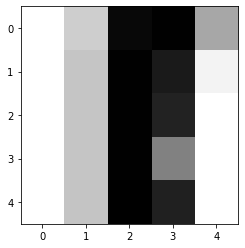

And the whole sample:


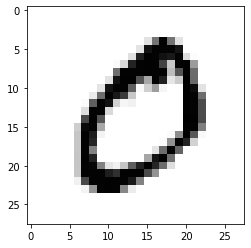

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [5]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

# Linear model

Your task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [6]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [7]:
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [27]:
# run this again if you remake your graph
s = reset_tf_session()

In [75]:
# run this again if you remake your graph
s = reset_tf_session()

## Model parameters: W and b
W = tf.get_variable(dtype=tf.float32, shape=(X_train_flat.shape[1], y_train_oh.shape[1]), name="variable_weights")
# b = tf.get_variable(dtype=tf.float32, shape=(1, y_train_oh.shape[1]), name="variable_bias")
b = tf.get_variable(dtype=tf.float32, shape=(y_train_oh.shape[1],), name="variable_bias")

print("W: {}, b: {}".format(W.shape, b.shape))

W: (784, 10), b: (10,)


In [76]:
# Placeholders for the input data
input_X = tf.placeholder(dtype=tf.float32, shape=(None, X_train_flat.shape[1]))
input_y = tf.placeholder(dtype=tf.float32, shape=(None, y_train_oh.shape[1]))

print("inputX: {}, input_y: {}".format(input_X.shape, input_y.shape))

inputX: (None, 784), input_y: (None, 10)


In [77]:
# Compute predictions

# logits for input_X, resulting shape should be [input_X.shape[0], 10]
logits = input_X @ W + b

# apply tf.nn.softmax to logits
probas = tf.nn.softmax(logits)

# apply tf.argmax to find a class index with highest probability
classes = tf.argmax(probas, axis=1)


# Loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=input_y))

# Use a default tf.train.AdamOptimizer to get an SGD step
step = tf.train.AdamOptimizer(0.01).minimize(loss)

In [78]:
print("W: {}, b: {}".format(W.shape, b.shape))
print("inputX: {}, input_y: {}".format(input_X.shape, input_y.shape))
print("logits: {}".format(logits.shape))

W: (784, 10), b: (10,)
inputX: (None, 784), input_y: (None, 10)
logits: (None, 10)


In [79]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="data:image/jpeg;base64,iVBORw0KGgoAAAANSUhEUgAAA2AAAAEgCAYAAADSVRDhAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy%2BWH4yJAAAgAElEQVR4nOzde3yO9f/A8de9s9nGNqedbHbAzGbYmHKOnBeRcxRSonyVHBLp9FORUkSoREVyLnIskjDHNIdsGDtmmx3ZeZ/fH1cu7nYgh814Px%2BP67H7vq7PdV2f6zb3vff9/lzvj0EppRBCCCGEEEIIcdeZlHcHhBBCCCGEEOJBIQGYEEIIIYQQQpQRCcCEEEIIIYQQooxIACaEEEIIIYQQZUQCMCGEEEIIIYQoIxKACSGEEEIIIUQZkQBMCCGEEEIIIcqIBGBCCCGEEEIIUUYkABNCCCGEEEKIMiIBmBBCCCGEEEKUEQnAhBBCCCGEEKKMSAAmhBBCCCGEEGVEAjAhhBBCCCGEKCMSgAkhhBBCCCFEGZEATAghhBBCCCHKiARgQgghhBBCCFFGJAATQgghhBBCiDIiAZgQQgghhBBClBEJwIQQQgghhBCijEgAJoT4z3bu3Imrq2t5d0MIIYQQosKRAEyIe1B%2Bfn55d%2BG23Q/XIIQQFY1SisLCwvLuhhCiFBKACVHGoqOjefzxx6levTqOjo6MGTOGJUuW8PDDDzNu3DgcHR2ZPn06aWlpDBkyhOrVq%2BPu7s7bb7%2Btf6hGRkbSpk0bqlSpQrVq1ejXrx%2BgffCOGzeOGjVqYGdnh7%2B/P%2BHh4SX25ccffyQwMJCqVavy0EMPcezYMX2bh4cHs2bNIiAggCpVqtCvXz%2Bys7O5fPkyXbp0IS4uDhsbG2xsbIiLi2P69On06dOHwYMHY2dnx5IlS4iLiyM0NBQHBwe8vb1ZtGiRfvyr7fv164etrS1NmjThjz/%2BAGDmzJn07t3bqK8vvvgiY8eOvWP/DkIIcTe9%2B%2B67eHl5YWtrS4MGDVi7dq2%2BbdGiRfj6%2BurbDh8%2BDBT/%2BQDa%2B%2BXgwYP1/aOiojAYDPoXXW3btmXKlCk8/PDDWFtbc/bsWb788kv9HJ6ennz22WdG/Vu/fj2BgYHY2dnh5eXF5s2b%2Bf7772natKlRu9mzZ/PYY4/dlddIiAeWEkKUmfz8fBUQEKD%2B97//qczMTJWVlaV2796tvvzyS2Vqaqo%2B/vhjlZeXp65cuaKefPJJFRoaqtLT09W5c%2BeUj4%2BPWrx4sVJKqf79%2B6u3335bFRQU6MdQSqnNmzerJk2aqJSUFFVYWKhOnDih4uLiiu3L4cOHVfXq1dW%2BfftUfn6%2BWrJkiXJ3d1fZ2dlKKaXc3d1VcHCwio2NVcnJyap%2B/fpq/vz5SimlfvnlF%2BXi4mJ0vNdff12ZmZmptWvXqoKCAnXlyhXVqlUrNWrUKJWVlaWOHDmiqlWrpnbs2GHU/vvvv1e5ublq5syZysPDQ%2BXm5qq4uDhlbW2tUlJSlFJK5eXlqerVq6uDBw/e%2BX8UIYS4C1auXKliY2NVQUGBWrFihbK2tlZxcXFq5cqVytnZWYWFhanCwkIVERGhoqKiSvx8UEp7vxw0aJB%2B7HPnzilA5eXlKaWUatOmjXJzc1Ph4eEqLy9P5ebmqh9//FFFRkaqwsJCtXPnTlWpUiV16NAhpZRS%2B/fvV3Z2dmrr1q2qoKBAxcTEqJMnT6rs7Gxlb2%2BvTpw4oZ8rMDBQrVq1qgxfOSHuf5IBE6IMhYWFERcXx8yZM6lcuTJWVla0bNkSAGdnZ1544QXMzMywsLBgxYoVzJgxA1tbWzw8PHj55ZdZtmwZAObm5pw/f564uDijY5ibm5ORkcGpU6dQSuHr64uTk1OxfVm4cCHPPvsszZs3x9TUlKFDh2Jpacm%2Bffv0Ni%2B%2B%2BCLOzs44ODjQo0cPjh49Wur1tWjRgp49e2JiYkJSUhJ79uzhvffew8rKisDAQEaMGMHSpUv19k2bNqVPnz6Ym5vz0ksvkZ2dzb59%2B3BycqJ169Z8//33AGzevJlq1aoV%2BWZWCCHuVU888QTOzs6YmJjQr18/fHx8CAsLY/HixUyYMIHg4GAMBgPe3t64u7uX%2BvlwM5566in8/PwwMzPD3Nycbt264eXlhcFgoE2bNjz66KPs3r0bgM8//5xhw4bRsWNHTExMcHFxoX79%2BlhaWtKvXz%2B%2B/vprAI4fP05UVBTdu3e/K6%2BREA8qCcCEKEPR0dG4u7tjZmZWZJubm5v%2BOCkpiby8PNzd3fV17u7uxMbGAvD%2B%2B%2B%2BjlKJZs2b4%2BfnxxRdfANC%2BfXvGjBnD6NGjqVGjBiNHjiQ9PZ0LFy7owwVtbGwAOH/%2BPB988AFVq1bVl%2BjoaOLi4vRz1qpVS39sbW1NZmZmqdd3/TXExcXh4OCAra1tsdfw7/YmJia4urrq5x86dKj%2BR8DXX3/Nk08%2BWeq5hRDiXrJ06VJ9iHfVqlUJDw8nKSmJ6OhovLy8irQv7fPhZlz/fgrw008/ERISgoODA1WrVmXTpk0kJSXp5yquD6C993777bcopVi2bBl9%2B/bF0tLylvokhCieBGBClCE3NzcuXLhQbIEKg8GgP65WrZqe5brqwoULuLi4AFpgtGjRIuLi4vjss894/vnniYyMBLSs1aFDhzhx4gSnT59m5syZ1K5dm8zMTH252pcpU6aQmpqqL1euXGHAgAE3vI7r%2B1rSemdnZy5dukRGRkax1wDaHwFXFRYWEhMTg7OzMwA9e/bk2LFjhIeH8%2BOPPzJo0KAb9ksIIe4F58%2Bf55lnnmHu3LkkJyeTmppKw4YNUUrh5ubGmTNniuxT2udD5cqVuXLliv48ISGhSJvr339zcnLo3bs348eP5%2B%2B//yY1NZWuXbuilNLPVVwfAEJCQrCwsGD37t18%2B%2B238uWXEHeBBGBClKFmzZrh5OTEpEmTuHz5MtnZ2ezZs6dIO1NTU/r27cuUKVPIyMjg/PnzzJ49W78J%2B/vvvycmJgYAe3t7DAYDJiYmHDhwgP3795OXl6cPYTExKf6/%2BTPPPMOCBQvYv38/SikuX77Mxo0bjQKmktSsWZPk5GTS0tJKbOPm5sZDDz3E5MmTyc7O5tixY3z%2B%2BedGN5IfOnSINWvWkJ%2Bfz0cffYSlpSUhISEAWFlZ0adPHwYOHEizZs2oXbv2DfslhBD3gsuXL2MwGKhevToAX375pV4QacSIEcyaNYtDhw6hlCIyMpLz58%2BX%2BvkQGBjIr7/%2ByoULF0hLS2PGjBmlnj83N5ecnByqV6%2BOmZkZP/30E1u3btW3Dx8%2BnC%2B//JIdO3ZQWFhIbGwsp06d0rcPGTKEMWPGYG5u/p%2BGQQohbo4EYEKUIVNTU3744QciIyOpXbs2rq6ufPfdd8W2/eSTT6hcuTKenp60bNmSgQMHMmzYMAAOHDhA8%2BbNsbGxITQ0lDlz5uDp6Ul6ejrPPPMM9vb2uLu74%2BjoyCuvvFLs8YOCgli0aBFjxozB3t4eb29vlixZclPXUb9%2BfQYMGICnpydVq1Y1GrZ4veXLlxMVFYWzszO9evXijTfeoEOHDvr2xx57jO%2B%2B%2Bw57e3uWLVvGmjVrMDc317cPHTqUP//8U76BFUJUKA0aNODll1%2BmRYsW1KxZkz///JOHH34Y0O4NmzJlCgMHDsTW1paePXty6dKlUj8fOnbsSL9%2B/QgICKBp06Y3vCfL1taWjz/%2BmL59%2B2Jvb8%2B3335LaGiovr1Zs2Z8%2BeWXjBs3jipVqtCmTRujERdPPvkk4

# Submit a linear model

In [100]:
## GRADED PART, DO NOT CHANGE!
# Testing shapes 
grader.set_answer("9XaAS", grading_utils.get_tensors_shapes_string([W, b, input_X, input_y, logits, probas, classes]))
# grader.set_answer("9XaAS", get_grader_shapes([W, b, input_X, input_y, logits, probas, classes]))
# Validation loss
grader.set_answer("vmogZ", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy
grader.set_answer("RMv95", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [101]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# MLP with hidden layers

Previously we've coded a dense layer with matrix multiplication by hand. 
But this is not convenient, you have to create a lot of variables and your code becomes a mess. 
In TensorFlow there's an easier way to make a dense layer:
```python
hidden1 = tf.layers.dense(inputs, 256, activation=tf.nn.sigmoid)
```

That will create all the necessary variables automatically.
Here you can also choose an activation function (remember that we need it for a hidden layer!).

Now define the MLP with 2 hidden layers and restart training with the cell above.

You're aiming for ~0.97 validation accuracy here.

In [118]:
# write the code here to get a new `step` operation and then run the cell with training loop above.
# name your variables in the same way (e.g. logits, probas, classes, etc) for safety.
### YOUR CODE HERE ###

hidden1 = tf.layers.dense(input_X, 256, activation=tf.nn.sigmoid)
hidden2 = tf.layers.dense(hidden1, 256, activation=tf.nn.sigmoid)

logits = tf.layers.dense(hidden2, 10, activation=None)

# apply tf.nn.softmax to logits
probas = tf.nn.softmax(logits)

# apply tf.argmax to find a class index with highest probability
classes = tf.argmax(probas, axis=1)


# Loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=input_y))

# Use a default tf.train.AdamOptimizer to get an SGD step
step = tf.train.AdamOptimizer(0.01).minimize(loss)

In [127]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="data:image/jpeg;base64,iVBORw0KGgoAAAANSUhEUgAAA2AAAAEgCAYAAADSVRDhAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy%2BWH4yJAAAgAElEQVR4nOzdd1hUx9cH8O9SLCggICouiNKkgwL2hok9IolEILaIJTEaW0yiQY3mF4MtvtaYWGKNYCzYRRNFNEZFREVjAwWk2EBA6WXP%2B8fIClIEFZaV83mefVzuzs6dueDunp2ZMxIiIjDGGGOMMcYYq3Iqim4AY4wxxhhjjNUWHIAxxhhjjDHGWDXhAIwxxhhjjDHGqgkHYIwxxhhjjDFWTTgAY4wxxhhjjLFqwgEYY4wxxhhjjFUTDsAYY4wxxhhjrJpwAMYYY4wxxhhj1YQDMMYYY4wxxhirJhyAMcYYY4wxxlg14QCMMcYYY4wxxqoJB2CMMcYYY4wxVk04AGOMMcYYY4yxasIBGGOMMcYYY4xVEw7AGGOMMcYYY6yacADGGGOMMcYYY9WEAzDGGGOMMcYYqyYcgDHGGGOMMcZYNeEAjDHGGGOMMcaqCQdgjLFKO3nyJAwNDRXdDMYYY4wxpcMBGGM1UH5%2BvqKb8MbehT4wxpiyISLIZDJFN4MxVg4OwBirZnFxcfjoo4%2Bgr68PPT09TJw4EZs2bULnzp0xdepU6OnpYe7cuUhLS8OIESOgr68PY2Nj/Pjjj/I31aioKHTv3h3a2tpo3LgxPD09AYg33qlTp6JJkybQ0tKCnZ0drl27VmZbDh48CEdHRzRq1AidOnVCRESE/LGWLVtiyZIlsLe3h7a2Njw9PZGdnY2MjAz069cPiYmJaNiwIRo2bIjExETMnTsXHh4eGDZsGLS0tLBp0yYkJibCzc0Nurq6MDMzw7p16%2BT1F5b39PSEpqYm2rZtiytXrgAAFi9ejMGDBxdr66RJkzB58uS39ntgjLGqtGDBApiamkJTUxPW1tYIDAyUP7Zu3TpYWVnJHwsPDwdQ%2BvsDIF4vhw0bJn9%2BTEwMJBKJ/IuuHj16wNfXF507d4aGhgbu3r2LjRs3ys9hYmKC3377rVj79u3bB0dHR2hpacHU1BRBQUHYuXMnnJycipVbunQpBg0aVCXXiLFaixhj1SY/P5/s7e1pypQplJ6eTllZWXT69GnauHEjqaqq0ooVKygvL48yMzNp%2BPDh5ObmRk%2BfPqXo6GgyNzen9evXExGRl5cX/fjjj1RQUCCvg4goKCiI2rZtSykpKSSTyej69euUmJhYalvCw8NJX1%2Bfzp07R/n5%2BbRp0yYyNjam7OxsIiIyNjYmFxcXSkhIoOTkZLK0tKQ1a9YQEVFwcDBJpdJi9X3//fekpqZGgYGBVFBQQJmZmdS1a1caP348ZWVl0aVLl6hx48Z0/PjxYuV37txJubm5tHjxYmrZsiXl5uZSYmIiaWhoUEpKChER5eXlkb6%2BPoWFhb39XwpjjFWBP//8kxISEqigoIACAgJIQ0ODEhMT6c8//6TmzZtTaGgoyWQyioyMpJiYmDLfH4jE6%2BXQoUPldUdHRxMAysvLIyKi7t27k5GREV27do3y8vIoNzeXDh48SFFRUSSTyejkyZNUv359unjxIhERnT9/nrS0tOjYsWNUUFBA8fHxdOPGDcrOziYdHR26fv26/FyOjo60a9euarxyjL37eASMsWoUGhqKxMRELF68GA0aNEC9evXQpUsXAEDz5s3x5ZdfQk1NDXXq1EFAQAD8/PygqamJli1b4quvvsLWrVsBAOrq6oiNjUViYmKxOtTV1fHs2TPcvHkTRAQrKysYGBiU2pa1a9fis88%2BQ/v27aGqqoqRI0eibt26OHfunLzMpEmT0Lx5c%2Bjq6mLgwIG4fPlyuf3r2LEj3N3doaKigqSkJJw5cwYLFy5EvXr14OjoiDFjxmDLli3y8k5OTvDw8IC6ujqmTZuG7OxsnDt3DgYGBujWrRt27twJAAgKCkLjxo1LfDPLGGM11ccff4zmzZtDRUUFnp6eMDc3R2hoKNavX49vvvkGLi4ukEgkMDMzg7GxcbnvDxXx6aefwsbGBmpqalBXV8eAAQNgamoKiUSC7t27o3fv3jh9%2BjQAYMOGDfDx8UGvXr2goqICqVQKS0tL1K1bF56enti2bRsA4L///kNMTAw%2B%2BOCDKrlGjNVWHIAxVo3i4uJgbGwMNTW1Eo8ZGRnJ7yclJSEvLw/GxsbyY8bGxkhISAAALFq0CESEdu3awcbGBr///jsAoGfPnpg4cSImTJiAJk2aYNy4cXj69Cnu3bsnny7YsGFDAEBsbCx%2B/vlnNGrUSH6Li4tDYmKi/JzNmjWT39fQ0EB6enq5/Svah8TEROjq6kJTU7PUPrxcXkVFBYaGhvLzjxw5Uv4hYNu2bRg%2BfHi552aMsZpky5Yt8inejRo1wrVr15CUlIS4uDiYmpqWKF/e%2B0NFFH09BYAjR46gQ4cO0NXVRaNGjXD48GEkJSXJz1VaGwDx2rt9%2B3YQEbZu3YohQ4agbt26r9UmxljpOABjrBoZGRnh3r17pSaokEgk8vuNGzeWj3IVunfvHqRSKQARGK1btw6JiYn47bff8MUXXyAqKgqAGLW6ePEirl%2B/jtu3b2Px4sVo0aIF0tPT5bfCtvj6%2BiI1NVV%2By8zMhLe39yv7UbStZR1v3rw5njx5gmfPnpXaB0B8CCgkk8kQHx%2BP5s2bAwDc3d0RERGBa9eu4eDBgxg6dOgr28UYYzVBbGwsxo4di1WrViE5ORmpqamwtbUFEcHIyAh37twp8Zzy3h8aNGiAzMxM%2Bc8PHjwoUabo629OTg4GDx6M6dOn4%2BHDh0hNTUX//v1BRPJzldYGAOjQoQPq1KmD06dPY/v27fzlF2NVgAMwxqpRu3btYGBggBkzZiAjIwPZ2dk4c%2BZMiXKqqqoYMmQIfH198ezZM8TGxmLp0qXyRdg7d%2B5EfHw8AEBHRwcSiQQqKiq4cOECzp8/j7y8PPkUFhWV0v%2Bbjx07Fr/%2B%2BivOnz8PIkJGRgYOHTpULGAqS9OmTZGcnIy0tLQyyxgZGaFTp06YOXMmsrOzERERgQ0bNhRbSH7x4kXs2bMH%2Bfn5WLZsGerWrYsOHToAAOrVqwcPDw988sknaNeuHVq0aPHKdjHGWE2QkZEBiUQCfX19AMDGjRvlCZHGjBmDJUuW4OLFiyAiREVFITY2ttz3B0dHR5w6dQr37t1DWloa/Pz8yj1/bm4ucnJyoK%2BvDzU1NRw5cgTHjh2TPz569Ghs3LgRx48fh0wmQ0JCAm7evCl/fMSIEZg4cSLU1dUrNQ2SMVYxHIAxVo1UVVVx4MABREVFoUWLFjA0NMSOHTtKLbty5Uo0aNAAJiYm6NKlCz755BP4%2BPgAAC5cuID27dujYcOGcHNzw/Lly2FiYoKnT59i7Nix0NHRgbGxMfT09PD111%2BXWr%2BzszPWrVuHiRMnQkdHB2ZmZti0aVOF%2BmFpaQlvb2%2BYmJigUaNGxaYtFuXv74%2BYmBg0b94cH374IebNm4f3339f/vigQYOwY8cO6OjoYOvWrdizZw/U1dXlj48cORJXr17lb2AZY0rF2toaX331FTp27IimTZvi6tWr6Ny5MwCxNszX1xeffPIJNDU14e7ujidPnpT7/tCrVy94enrC3t4eTk5Or1yTpampiRUrVmDIkCHQ0dHB9u3b4ebmJn%2B8Xbt22LhxI6ZOnQptbW1079692IyL4cOH49q1a8W%2BMGOMvT0SKhyPZoyxajR37lxERUXJ13mV5t69e7C0tMSDBw%2BgpaVVja1jjLHaKysrC02aNEF4eDjMz

# Submit the MLP with 2 hidden layers
Run these cells after training the MLP with 2 hidden layers

In [131]:
## GRADED PART, DO NOT CHANGE!
# Validation loss for MLP
grader.set_answer("i8bgs", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy for MLP
grader.set_answer("rE763", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [134]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!
